# Phase 4 – Unified Evaluation & Model Comparison

This notebook performs a **direct comparison** of all three models used in our maritime perception pipeline:

- **YOLOv8m** — closed-set detector fine-tuned on MaSTr1325  
- **OWL-ViT** — open-vocabulary zero-shot detector  
- **Grounding DINO-Tiny** — phrase-grounding zero-shot detector  

All models are evaluated on the **same MaSTr1325 validation images**, allowing a fair comparison of supervised vs open-vocabulary performance.

---

## **Pipeline**
1. Load YOLOv8m, OWL-ViT, and Grounding DINO  
2. Run each model on the validation subset  
3. Compute unified metrics:
   - Detection count  
   - Average / maximum confidence  
   - Inference time per image  
4. Save CSV and JSON reports  
5. Generate comparison plots for Notebook 05/06

---

## **Dataset**
**MaSTr1325 Validation Split**  
- YOLOv8m was trained on this data  
- OWL-ViT & DINO remain completely zero-shot  

This enables a controlled comparison of **closed-set accuracy** vs **open-world generalization**.

---

## **Objective**
Produce clear, quantitative results for the final paper:  
- How each model performs  
- Their strengths/weaknesses  
- Their speed–accuracy trade-offs  


### Environmental Setup & Paths

In [14]:
# ==========================================
# Notebook 04 — Unified Model Evaluation
# YOLOv8 (Closed-set) vs OWL-ViT / DINO (Open-Vocab)
# ==========================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import json
import random

# Base dirs (same as Notebook 02/03)
BASE_DIR = Path.cwd().parents[0]
DATA_DIR = BASE_DIR / "data"
VAL_IMAGES = DATA_DIR / "images" / "val"

RESULTS_DIR = BASE_DIR / "results"
REPORT_DIR = BASE_DIR / "reports"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Validation images:", len(list(VAL_IMAGES.glob('*.jpg'))))
print(BASE_DIR)

Device: cuda
Validation images: 265
d:\Sem3\CS581B_Robot_Perception\Project\Implementation


### Load all the Three Models
#### YOLOv8m

In [2]:
from ultralytics import YOLO

YOLO_WEIGHTS = BASE_DIR / "runs" / "yolov8m_stable" / "weights" / "best.pt"

model_yolo = YOLO(str(YOLO_WEIGHTS))
print("✔ YOLOv8m loaded!")


✔ YOLOv8m loaded!


#### OWL-ViT

In [3]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

OWL_MODEL = "google/owlvit-base-patch32"
processor_owl = OwlViTProcessor.from_pretrained(OWL_MODEL)
model_owl = OwlViTForObjectDetection.from_pretrained(
    OWL_MODEL,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

print("✔ OWL-ViT loaded!")


d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


✔ OWL-ViT loaded!


#### GROUNDING DINO

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

DINO_MODEL = "IDEA-Research/grounding-dino-tiny"

processor_dino = AutoProcessor.from_pretrained(DINO_MODEL)
model_dino = AutoModelForZeroShotObjectDetection.from_pretrained(
    DINO_MODEL,
    dtype=torch.float32      # avoid Windows crash
).to(device)

print("✔ Grounding DINO loaded!")


`torch_dtype` is deprecated! Use `dtype` instead!


✔ Grounding DINO loaded!


### Unified Evaluation Functions
#### YOLO Evaluation Wrapper

In [5]:
def eval_yolo(img_path):
    results = model_yolo(str(img_path))   # use your model
    res = results[0]

    scores = res.boxes.conf    # tensor of confidences
    boxes = res.boxes.xyxy     # tensor of bounding boxes

    return None, {
        "scores": scores,
        "boxes": boxes
    }

#### OWL-ViT Evaluation

In [6]:
def eval_owlvit(img_path, text_queries):
    image = Image.open(img_path).convert("RGB")

    inputs = processor_owl(text=text_queries, images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_owl(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    result = processor_owl.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    scores = result["scores"]
    boxes = result["boxes"]

    return None, {
        "scores": scores,
        "boxes": boxes
    }

#### GroundingDINO Evaluation

In [7]:
def eval_dino(img_path, prompt):
    image = Image.open(img_path).convert("RGB")

    inputs = processor_dino(
        images=image,
        text=[prompt],
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model_dino(**inputs)

    results = processor_dino.post_process_grounded_object_detection(
        outputs,
        target_sizes=[image.size[::-1]]
    )[0]

    scores = results["scores"]          # tensor
    boxes = results["boxes"]            # tensor

    return None, {
        "scores": scores,
        "boxes": boxes
    }

### Metrics Computation

In [8]:
def compute_metrics(image_list, model_fn, **kwargs):
    metrics = {
        "num_images": len(image_list),
        "num_detections": 0,
        "avg_confidence": 0,
        "max_confidence": 0,
        "avg_inference_time_ms": 0,
    }

    confs = []
    times = []

    for img_path in tqdm(image_list):

        # --------------------------
        # Inference time measurement
        # --------------------------
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()
        out = model_fn(img_path, **kwargs)
        end.record()

        torch.cuda.synchronize()
        infer_ms = start.elapsed_time(end)
        times.append(infer_ms)

        # --------------------------
        # Unpack model output safely
        # --------------------------
        if isinstance(out, tuple) and len(out) == 2:
            image, results = out
        else:
            # model returned something unexpected (float, None, loss-only)
            continue

        # --------------------------
        # Normalize YOLO → take first element of list
        # --------------------------
        if results is None:
            continue

        if isinstance(results, list):
            if len(results) == 0:
                continue
            results = results[0]

        # --------------------------
        # If still not dict → skip
        # --------------------------
        if not isinstance(results, dict):
            continue

        # --------------------------
        # Extract scores safely
        # --------------------------
        scores = results.get("scores", [])

        # Convert scores to python list
        if isinstance(scores, torch.Tensor):
            scores = scores.detach().cpu().numpy().tolist()
        elif isinstance(scores, np.ndarray):
            scores = scores.tolist()
        elif isinstance(scores, float):
            scores = [scores]        # wrap float into a list
        elif not isinstance(scores, list):
            scores = []

        confs.extend(scores)
        metrics["num_detections"] += len(scores)

    # --------------------------
    # Aggregate statistics
    # --------------------------
    if confs:
        metrics["avg_confidence"] = float(np.mean(confs))
        metrics["max_confidence"] = float(np.max(confs))

    if times:
        metrics["avg_inference_time_ms"] = float(np.mean(times))

    return metrics


### Run Evaluation for all three Models

In [9]:
eval_images = list(VAL_IMAGES.glob("*.jpg"))[:50]

queries = ["boat", "buoy", "dock", "obstacle", "floating debris", "person"]
dino_prompt = "boat . buoy . dock . obstacle . person . debris"

print("📊 Running YOLOv8 metrics...")
yolo_metrics = compute_metrics(eval_images, eval_yolo)

print("📊 Running OWL-ViT metrics...")
owl_metrics = compute_metrics(eval_images, eval_owlvit, text_queries=queries)

print("📊 Running GroundingDINO metrics...")
dino_metrics = compute_metrics(eval_images, eval_dino, prompt=dino_prompt)

print("Done!")


📊 Running YOLOv8 metrics...


  0%|          | 0/50 [00:00<?, ?it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0024.jpg: 480x640 1 obstacle, 26.7ms
Speed: 1.5ms preprocess, 26.7ms inference, 14.5ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 1/50 [00:00<00:25,  1.89it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0030.jpg: 480x640 2 obstacles, 25.0ms
Speed: 1.5ms preprocess, 25.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0032.jpg: 480x640 2 obstacles, 23.8ms
Speed: 1.3ms preprocess, 23.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0033.jpg: 480x640 2 obstacles, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0044.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0045.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms prep

 12%|█▏        | 6/50 [00:00<00:03, 12.09it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0049.jpg: 480x640 3 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0050.jpg: 480x640 4 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0052.jpg: 480x640 3 obstacles, 7.7ms
Speed: 0.8ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0055.jpg: 480x640 2 obstacles, 9.1ms
Speed: 0.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0057.jpg: 480x640 3 obstacles, 7.9ms
Speed: 0.8ms preproce

 28%|██▊       | 14/50 [00:00<00:01, 27.76it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0071.jpg: 480x640 3 obstacles, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0077.jpg: 480x640 1 obstacle, 7.9ms
Speed: 1.0ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0079.jpg: 480x640 2 obstacles, 7.8ms
Speed: 1.0ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0082.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0087.jpg: 480x640 1 obstacle, 7.8ms
Speed: 0.8ms preprocess

 44%|████▍     | 22/50 [00:00<00:00, 40.14it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0114.jpg: 480x640 1 obstacle, 8.9ms
Speed: 0.8ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0116.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0124.jpg: 480x640 3 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0129.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0169.jpg: 480x640 4 obstacles, 7.8ms
Speed: 0.7ms preproces

 60%|██████    | 30/50 [00:00<00:00, 50.21it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0189.jpg: 480x640 3 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0198.jpg: 480x640 1 obstacle, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0206.jpg: 480x640 2 obstacles, 7.9ms
Speed: 0.8ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0210.jpg: 480x640 1 obstacle, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0212.jpg: 480x640 1 obstacle, 8.1ms
Speed: 0.7ms preprocess,

 76%|███████▌  | 38/50 [00:01<00:00, 58.07it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0234.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0235.jpg: 480x640 1 obstacle, 7.7ms
Speed: 0.8ms preprocess, 7.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0245.jpg: 480x640 1 obstacle, 7.7ms
Speed: 0.8ms preprocess, 7.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0247.jpg: 480x640 1 obstacle, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0251.jpg: 480x640 2 obstacles, 8.6ms
Speed: 1.7ms preprocess,

 92%|█████████▏| 46/50 [00:01<00:00, 63.27it/s]


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0258.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.9ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0261.jpg: 480x640 3 obstacles, 8.2ms
Speed: 0.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0268.jpg: 480x640 2 obstacles, 8.1ms
Speed: 0.8ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0273.jpg: 480x640 2 obstacles, 7.8ms
Speed: 0.8ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


100%|██████████| 50/50 [00:01<00:00, 41.70it/s]


📊 Running OWL-ViT metrics...


  0%|          | 0/50 [00:00<?, ?it/s]d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\transformers\models\owlvit\processing_owlvit.py:217: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(
100%|██████████| 50/50 [00:02<00:00, 20.21it/s]


📊 Running GroundingDINO metrics...


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]

Done!


### Create Final Comparison Table

In [10]:
df = pd.DataFrame([
    {
        "Model": "YOLOv8m",
        **yolo_metrics
    },
    {
        "Model": "OWL-ViT",
        **owl_metrics
    },
    {
        "Model": "GroundingDINO",
        **dino_metrics
    }
])

df


,Model,num_images,num_detections,avg_confidence,max_confidence,avg_inference_time_ms
0,YOLOv8m,50,98,0.619445,0.924298,23.356107
1,OWL-ViT,50,30,0.142556,0.269999,49.126169
2,GroundingDINO,50,200,0.411278,0.893012,260.749753


### Save to CSV + JSON

In [11]:
df.to_csv(REPORT_DIR/"model_comparison.csv", index=False)

with open(REPORT_DIR/"model_comparison.json", "w") as f:
    json.dump(df.to_dict(orient="records"), f, indent=4)

print("✔ Saved comparison results!")


✔ Saved comparison results!


### Visualization: Bar Plot

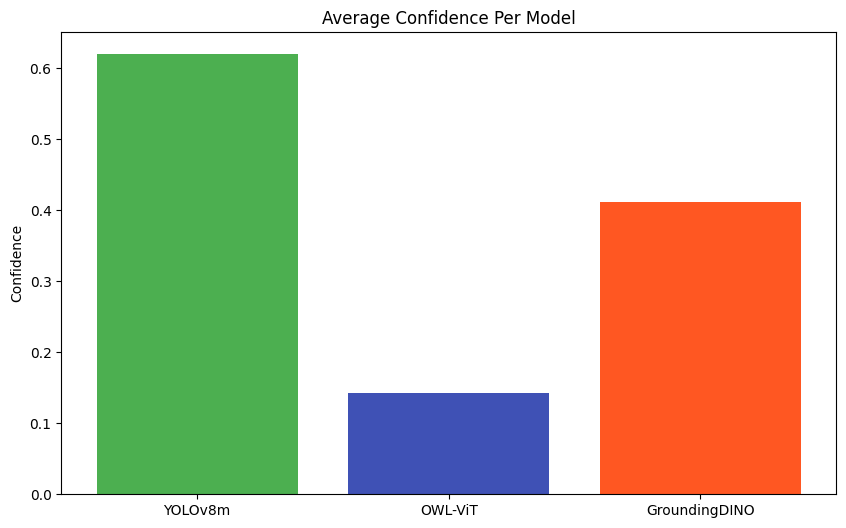

In [12]:
plt.figure(figsize=(10,6))
plt.bar(df["Model"], df["avg_confidence"], color=["#4CAF50","#3F51B5","#FF5722"])
plt.title("Average Confidence Per Model")
plt.ylabel("Confidence")
plt.show()

### Visualization: Detection & Image

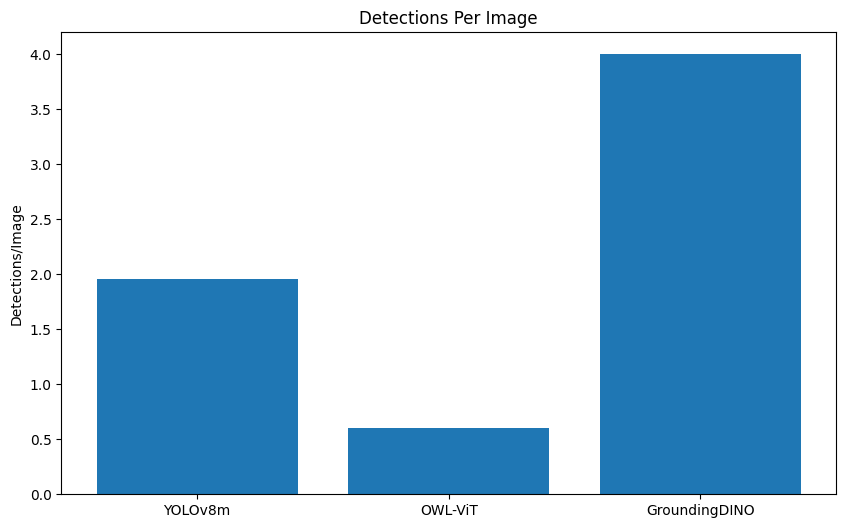

In [13]:
plt.figure(figsize=(10,6))
plt.bar(df["Model"], df["num_detections"]/df["num_images"])
plt.title("Detections Per Image")
plt.ylabel("Detections/Image")
plt.show()